In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lmfit
from lmfit import  Model, Parameters
lmfit.__version__

'0.9.10'

In [2]:
from sympy import *
#from sympy.interactive import printing # Pour avoir des belles sorties ...
#printing.init_printing(use_latex=True) # ... en LaTeX
#from IPython.display import display

''' -------------------------------------------------------------------------
def velocity (x, bino, start_anti, v_anti, latence, tau, maxi) :
    v_anti = v_anti/1000 # pour passer de sec à ms
    time = x # np.arange(len(x))
    vitesse = []

    didi = (bino*2-1)
    
    for t in range(len(time)):
        x_lat = time[t]-latence
        x_start = time[t]-start_anti
        
        if start_anti >= latence :
            if time[t] < latence :
                vitesse.append(0)
            else :
                vitesse.append(didi*maxi*(1-np.exp(-x_lat/tau)))
        else :
            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if time[t] < latence :
                    vitesse.append(x_start*v_anti)
                    y = x_start*v_anti
                else :
                    vitesse.append(didi*maxi*(1-np.exp(-x_lat/tau))+y)

    return vitesse
-------------------------------------------------------------------------------'''

x, x_lat, x_start, didi, start_anti, v_anti, latence, tau, maxi, y = symbols('x, x_lat,x_start, didi, start_anti, v_anti, latence, tau, maxi, y')

F1 = didi*maxi*(1-exp(-x_lat/tau))
print(F1, '->', integrate(F1, x_lat)) #display(F1, integrate(F1, xlat))

F2 = x_start*v_anti # (x-start_anti)*v_anti
print(F2, '->', integrate(F2, x_start)) #display(F2, integrate(F2, xstart))

F3 = didi*maxi*(1-exp(-x_lat/tau))
print(F3, '->', integrate(F3, x_lat)) #display(F3, integrate(F3, xlat))

didi*maxi*(1 - exp(-x_lat/tau)) -> didi*maxi*tau*exp(-x_lat/tau) + didi*maxi*x_lat
v_anti*x_start -> v_anti*x_start**2/2
didi*maxi*(1 - exp(-x_lat/tau)) -> didi*maxi*tau*exp(-x_lat/tau) + didi*maxi*x_lat


In [3]:
import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier :
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
    
datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

In [4]:
block = 0
trial = 78

#-----------------------------------------
N_trials = exp['N_trials']
screen_width_px = exp['screen_width_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']
#-----------------------------------------

trial_data = trial + N_trials*block

time = data[trial_data]['trackertime']
StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac'] #[starttime, endtime, duration, startx, starty, endx, endy]
t_0 = data[trial_data]['trackertime'][0]

DATA_x = data[trial_data]['x']
data_x = DATA_x-(DATA_x[StimulusOf-t_0-100])
#data_x = DATA_x-(exp['screen_width_px']/2)

bino=p[trial, block, 0]

start = TargetOn
start1 = TargetOn-t_0

1871 0


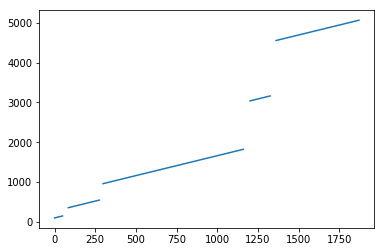

In [5]:
def position_nan (x, bino, start_anti, v_anti, latence, tau, maxi) :
    v_anti = v_anti/1000 # pour passer de sec à ms
    time = x
    
    didi, avant, apres = (bino*2-1), 5, 10 #15
    vitesse, lala = [], []
    
    #--------------------------------------------------
    for s in range(len(saccades)) :
        
        if saccades[s][1]-t_0+apres <= (len(time)) :
            lala.append(saccades[s][1]-t_0+apres)
        else :
            lala.append(len(time))
    #--------------------------------------------------
    a, s = 0, 0

    for t in range(len(time)):
        
        x_lat = time[t]-latence
        x_start = time[t]-start_anti
        
        if t in np.arange((saccades[s][0]-t_0-avant), lala[s]) :
            if t > 0 :
                vitesse.append(np.nan)
                a = vitesse[saccades[s][0]-t_0-avant-1]+((saccades[s][5]-saccades[s][3]))
            else :
                vitesse.append(np.nan)
                a = 0+((saccades[s][5]-saccades[s][3]))
            
            if t == lala[s]-1 :
                if s < len(saccades)-1 :
                    s = s+1
            
        else :
            if start_anti >= latence :
                if time[t] < latence :
                    vitesse.append(0)
                else :
                    #vitesse.append(a + didi*maxi*(x_lat + (1/tau)*(np.exp(-x_lat/tau)-1))) 
                    vitesse.append(a + didi*maxi*(x_lat + tau*(np.exp(-x_lat/tau)))) 
            else :
                if time[t] < start_anti :
                    vitesse.append(0)
                else :
                    if time[t] < latence :
                        vitesse.append(a + (v_anti*x_start**2)/2)
                        y = a + (v_anti*x_start**2)/2
                    else :
                        #vitesse.append(didi*maxi*(x_lat + (1/tau)*(np.exp(-x_lat/tau)-1)) + y)
                        vitesse.append(didi*maxi*(tau*np.exp(-x_lat/tau)+x_lat) +y)

                    
    return vitesse

a = position_nan (np.arange(len(time)), 1, 100, 1.2, -100, 1, 1)
plt.plot(a);
print(len(time), len(time)-len(a))

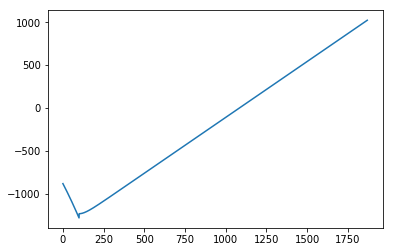

In [23]:
def position (x, bino, start_anti, v_anti, latence, tau, maxi) :
    v_anti = v_anti/1000 # pour passer de sec à ms
    time = x
    vitesse = []
    didi = (bino*2-1)

    for t in range(len(time)):
        
        x_lat = time[t]-latence
        x_start = time[t]-start_anti
        
        
        if start_anti >= latence :
            if time[t] < latence :
                vitesse.append(0)
            else :
                #vitesse.append((didi*maxi*tau*np.exp((-(time[t]-latence))/tau)) + (didi*maxi*(time[t]-latence)))
                #vitesse.append(didi*maxi*(x_lat + (tau)*(np.exp(-x_lat/tau)-1)))
                vitesse.append(didi*maxi*(tau*np.exp(-x_lat/tau)+x_lat) +y)
        else :

            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if time[t] < latence :
                    vitesse.append((v_anti*x_start**2)/2)
                    y = (v_anti*x_start**2)/2
                else :
                    vitesse.append(didi*maxi*(tau*np.exp(-x_lat/tau)+x_lat) +y)
                    #vitesse.append(didi*maxi*(x_lat + (tau)*(np.exp(-x_lat/tau)-1)) + y)
                    
                    
    return vitesse

a = position (np.arange(len(time)), 1,-481, -7.6, 100, 37.6, 1.3)
plt.plot(a);

In [24]:
def target(time, bino, TargetOn, RashBass, V_X):
    dir_bool = bino*2 - 1
    Target_trial = []
    x = 0
    for t in range(len(time)):
        if t < (TargetOn) :
            x = 0
        elif t == (TargetOn) :
            # la cible à t=0 recule de sa vitesse * latence=RashBass (ici mis en ms)
            x = x -(dir_bool * ((V_X/1000)*RashBass))
        elif (t > (TargetOn) and t <= ((TargetOn)+stim_tau*1000)) :
            x = x + (dir_bool*(V_X/1000))
        else :
            x = x
        Target_trial.append(x)
    return Target_trial

def deco(axs) :
    axs.plot(time-start,target(time, bino, TargetOn-t_0, RashBass, V_X), '--k', alpha=0.4, linewidth=1.5)
    axs.axvspan(StimulusOn-start, StimulusOf-start, color='k', alpha=0.2)
    axs.axvspan(StimulusOf-start, TargetOn-start, color='r', alpha=0.2)
    axs.axvspan(TargetOn-start, TargetOff-start, color='k', alpha=0.15)
    for s in range(len(saccades)) :
        axs.axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

In [25]:
def Fit_position(velocity_x, trackertime, bino, param_fit=None, TargetOn=TargetOn,
                 StimulusOf=StimulusOf, saccades=saccades, sup=False, time_sup=-280, step=2,
                 nan=False) :

    from lmfit import  Model, Parameters

    t_0 = trackertime[0]

    if param_fit is None :
        param_fit={'tau':[15.,13.,80.], 'maxi':[15.,0.,40], 'v_anti':[0.,-40.,40.], 'latence':[TargetOn-t_0+100,TargetOn-t_0+75,'STOP'],
                   'start_anti':[TargetOn-t_0-100, StimulusOf-t_0-200, TargetOn-t_0+75]}

    if param_fit['latence'][2]=='STOP' :
        stop_latence = []
        for s in range(len(saccades)) :
            if (saccades[s][0]-t_0) >= (TargetOn-t_0+100) :
                stop_latence.append((saccades[s][0]-t_0))
        if stop_latence==[] :
            stop_latence.append(len(time))
        stop = stop_latence[0]
    else :
        stop = param_fit['latence'][2]


    if sup==True :
        velocity_x = velocity_x[:time_sup]
        trackertime = trackertime[:time_sup]

    if nan==True :
        model = Model(position_nan)
    else :
        model = Model(position)
    params = Parameters()

    if step == 1 :
        vary = True
    elif step == 2 :
        vary = False

    params.add('maxi', value=param_fit['maxi'][0], min=param_fit['maxi'][1], max=param_fit['maxi'][2])
    params.add('latence', value=param_fit['latence'][0], min=param_fit['latence'][1], max=stop)
    params.add('bino', value=bino, vary=False)
    params.add('tau', value=param_fit['tau'][0], min=param_fit['tau'][1], max=param_fit['tau'][2], vary=vary)
    params.add('start_anti', value=param_fit['start_anti'][0], min=param_fit['start_anti'][1], max=param_fit['start_anti'][2], vary=vary)
    params.add('v_anti', value=param_fit['v_anti'][0], min=param_fit['v_anti'][1], max=param_fit['v_anti'][2], vary=vary)

    if step == 1 :
        result_deg = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')

    elif step == 2 :
        out = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')
        out.params['tau'].set(vary=True)
        out.params['start_anti'].set(vary=True)
        out.params['v_anti'].set(vary=True)

        result_deg = model.fit(velocity_x, out.params, x=np.arange(len(trackertime)), method='nelder', nan_policy='omit')
                                
    return result_deg


In [26]:
data = np.copy(data_x)
  
t_0 = time[0]
avant=5
apres=10 #15
for s in range(len(saccades)) :
    if saccades[s][1]-t_0+apres <= (len(time)) :
        for x_data in np.arange((saccades[s][0]-t_0-avant), (saccades[s][1]-t_0+apres)) :
            data[x_data] = np.nan
    else :
        for x_data in np.arange((saccades[s][0]-t_0-avant), (len(time))) :
            data[x_data] = np.nan
            
# data2 = np.copy(data)           
data3 = np.copy(data)
a = 0
for s in range(len(saccades)) :
    a = a + (data[saccades[s][1]-t_0+apres]-data[saccades[s][0]-t_0-avant-1])
    b = ((data[saccades[s][0]-t_0-avant-1]-data[saccades[s][0]-t_0-avant-101])/100)
    if s < len(saccades)-1 :
        for x_data in np.arange((saccades[s][1]-t_0+apres), (saccades[s+1][0]-t_0-avant)) :
            # data2[x_data] = data2[x_data]-a
            data3[x_data] = data3[x_data]-a+((saccades[s][1]-t_0+apres)-(saccades[s][0]-t_0-avant))*b
    else :
        for x_data in np.arange((saccades[s][1]-t_0+apres), len(time)) :
            # data2[x_data] = data2[x_data]-a
            data3[x_data] = data3[x_data]-a+((saccades[s][1]-t_0+apres)-(saccades[s][0]-t_0-avant))*b

-383.29161415578903 -17.081461615095108 100.00173818124426 13.540658581176961 0.4830403988029852
-100.24264675152494 -1.7686904643562684 99.9999985186198 64.12388841076647 0.5972041001525685


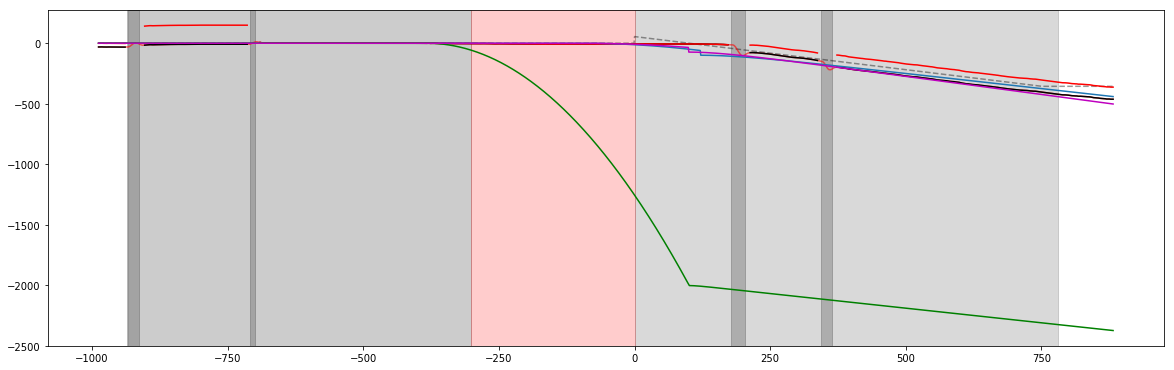

In [27]:
fig_width= 20
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
deco(axs)

data3 = data3-(data3[StimulusOf-t_0-100])

axs.plot(time-start, data_x, color='r', alpha=0.6)
axs.plot(time-start, data, c='k')
# axs.plot(time-start, data2, c='k', alpha=0.5)           
axs.plot(time-start, data3, c='r')

#--------------------------------------------------------------------------------------------
axs.plot(time-start, position (time-start, 0, -100, -2.47, 121.2, 78, 0.5))
#--------------------------------------------------------------------------------------------

a = Fit_position(data3,time, bino,step=1)
b = position(np.arange(len(time)), bino, a.values['start_anti'], a.values['v_anti'], a.values['latence'], a.values['tau'], a.values['maxi'])
#c = position(np.arange(len(time)), bino, a.init_values['start_anti'], a.init_values['v_anti'], a.init_values['latence'], a.init_values['tau'], a.init_values['maxi'])
print(a.values['start_anti']-start1, a.values['v_anti'], a.values['latence']-start1, a.values['tau'], a.values['maxi'])
axs.plot(time-start, b, c='g')



a = Fit_position(data,time, bino,step=1, nan=True)
b = position(np.arange(len(time)), bino, a.values['start_anti'], a.values['v_anti'], a.values['latence'], a.values['tau'], a.values['maxi'])
print(a.values['start_anti']-start1, a.values['v_anti'], a.values['latence']-start1, a.values['tau'], a.values['maxi'])
axs.plot(time-start, b, c='m');

In [22]:
param['start_anti'][block][trial]

67.92511812740463

In [12]:
param['v_anti'][block][trial]

-30.583410736466785

In [13]:
param['latence'][block][trial]

161.98752404899938

In [14]:
param['tau'][block][trial]

45.86681922544738

In [15]:
param['maxi'][block][trial]

13.041872931017215